In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

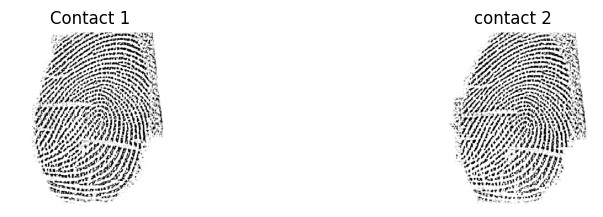

In [3]:
contact_image_raw_1 = cv2.imread('../PolyU/contact-based_fingerprints/first_session/1_1.jpg')
contact_image_gray_1 = cv2.cvtColor(contact_image_raw_1, cv2.COLOR_BGR2GRAY)

contact_image_raw_2 = cv2.imread('../PolyU/contact-based_fingerprints/first_session/1_2.jpg')
contact_image_gray_2 = cv2.cvtColor(contact_image_raw_2, cv2.COLOR_BGR2GRAY)
# contact_image_gray_2 = cv2.flip(contact_image_gray_2, 0)
# contact_image_gray_2 = cv2.rotate(contact_image_gray_2, cv2.ROTATE_90_COUNTERCLOCKWISE)


plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(contact_image_gray_1, cmap='gray')
plt.title('Contact 1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(contact_image_gray_2, cmap='gray')
plt.title('contact 2')
plt.axis('off')
plt.show()

In [4]:
def align_fingerprints(img1, img2, verbose = False):
    # Step 1: Convert images to grayscale
    # gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    # gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Step 2: Detect ORB key points and descriptors
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    
    # Step 3: Match key points using FLANN matcher
    index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=2)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    matches = flann.knnMatch(des1, des2, k=2)
    # Filter matches using Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    if verbose:
        matched_image = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        
        # Display matched keypoints
        plt.figure(figsize=(15, 10))
        plt.title('Matched Keypoints')
        plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    # matchesMask = [[0,0] for i in range(len(matches))]
 
    # # ratio test.
    # for i,(m,n) in enumerate(matches):
    #     if( m.distance < 0.1*n.distance):
    #         matchesMask[i]=[1,0]
    # draw_params = dict(matchColor = (0,255,0),
    #                    singlePointColor = (255,0,0),
    #                    matchesMask = matchesMask,flags = 0)
     
    # # drawing nearest neighbours
    # img = cv.drawMatchesKnn(main_image,
    #                         key_point1,
    #                         sub_image,
    #                         key_point2,
    #                         matches,
    #                         None,
    #                         **draw_params)
    # return img
    
    # Check if enough matches are found
    MIN_MATCH_COUNT = 10
    if len(good_matches) > MIN_MATCH_COUNT:
        # Extract locations of good matches
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # Step 4: Compute homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Step 5: Warp one image to align with the other
        h, w = img1.shape[:2]
        aligned_img = cv2.warpPerspective(img1, M, (w, h))
        if verbose:
            print(M,w, h)
            print(f'good matches:{len(good_matches)}')
            # Display the aligned image and the original for comparison
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title('Original Image')
            plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
            
            plt.subplot(1, 2, 2)
            plt.title('Aligned Image')
            plt.imshow(cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB))
            
            plt.show()
            print('Matched')
            return aligned_img
        else:
            return True
    else:
        if verbose:
            print("Not Matched")
            return None
        else:
            return False

In [5]:
matching = align_fingerprints(contact_image_gray_1, contact_image_gray_2, verbose=True)

Not Matched


In [6]:
def pre_process_contactless(person, id):
    contactless_image_raw = cv2.imread(f'../PolyU/processed_contactless_2d_fingerprint_images/first_session/p{person}/p{id}.bmp')
    contactless_image_gray = cv2.cvtColor(contactless_image_raw, cv2.COLOR_BGR2GRAY)

    # Histogram Equi
    equilized_image = cv2.equalizeHist(contactless_image_gray)
    # AMT
    AMT_image = cv2.adaptiveThreshold(equilized_image,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)

    #gabor
    ksize = 21  # Size of the Gabor kernel
    sigma = 5.0  # Standard deviation of the Gaussian envelope
    theta = 0  # Orientation of the normal to the parallel stripes
    lambd = 10.0  # Wavelength of the sinusoidal factor
    gamma = 0.5  # Spatial aspect ratio
    phi = 0  # Phase offset
    
    # Generate Gabor kernel
    gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, phi, ktype=cv2.CV_32F)
    gabor_filtered_1 = cv2.filter2D(AMT_image, cv2.CV_8UC3, gabor_kernel)
    return AMT_image



(-0.5, 349.5, 224.5, -0.5)

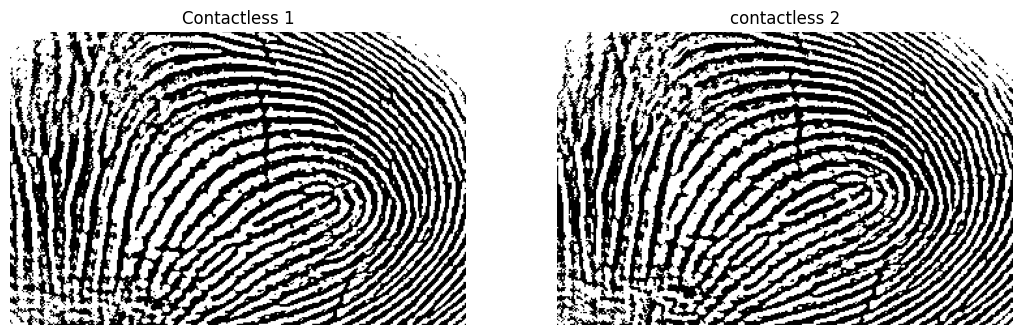

In [7]:
# Pre-Processing for contactless 1
AMT_image_1 = pre_process_contactless(person = 1, id = 1)
AMT_image_2 = pre_process_contactless(person = 1, id = 2)

plt.figure(figsize=(20, 15))

plt.subplot(2, 3, 1)
plt.imshow(AMT_image_1, cmap='gray')
plt.title('Contactless 1')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(AMT_image_2, cmap='gray')
plt.title('contactless 2')
plt.axis('off')

[[ 9.99770483e-01  2.52102871e-02 -1.29686238e+01]
 [ 5.63238537e-03  1.01977907e+00 -1.07214781e+01]
 [-8.29945467e-05  1.92687088e-04  1.00000000e+00]] 350 225
good matches:43


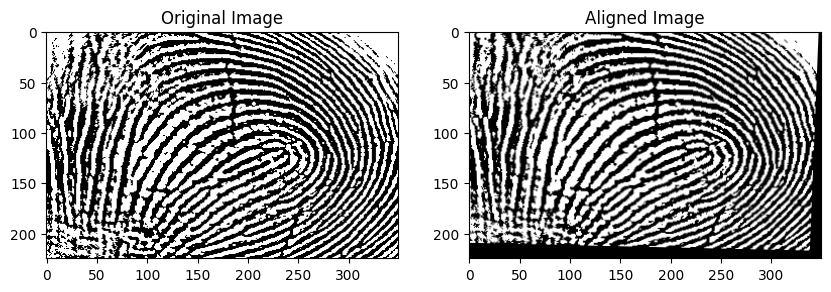

Matched


In [8]:
aligned_image = align_fingerprints(AMT_image_1, AMT_image_2, verbose=True)

In [12]:
print(np.arange(6,6))

[]


Not Matched
failed person:2 id :4 6


Not Matched
failed person:4 id :1 6


Not Matched
failed person:4 id :2 6


Not Matched
failed person:4 id :3 6


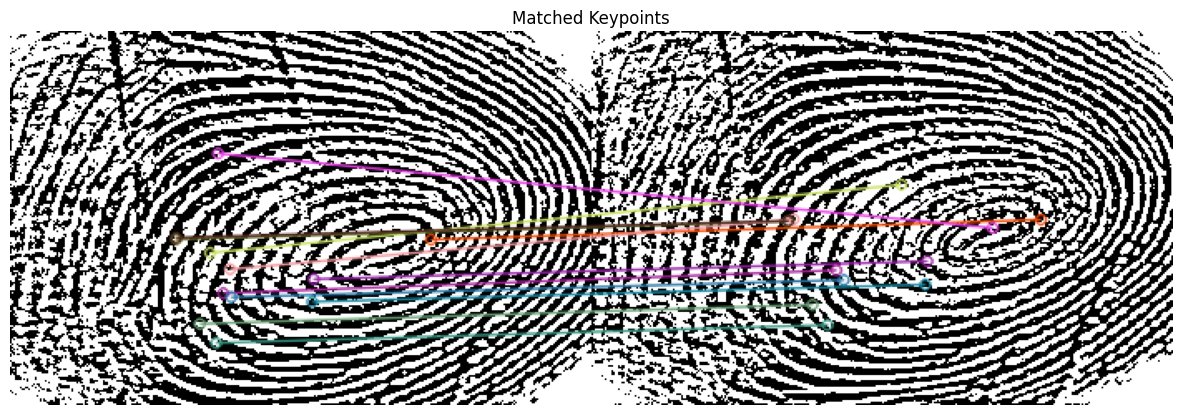

[[ 8.62285139e-01 -8.85083827e-02  3.17050291e+01]
 [-1.62446309e-02  7.77059555e-01  7.46652159e+00]
 [-1.15683616e-04 -6.97671806e-04  1.00000000e+00]] 350 225
good matches:12


Matched
failed person:4 id :4 6


Not Matched
failed person:4 id :5 6
percentage_of_fails 0.08


In [19]:
total_persons = 5

fails = 0
for i in np.arange(1,total_persons +1):
    for id1 in np.arange(1,7):
        for id2 in np.arange(id1+1, 7):
            img1 = pre_process_contactless(person = i, id = id1)
            img2 = pre_process_contactless(person = i, id = id2)
            match = align_fingerprints(img1, img2)
            if not match:
                fails += 1
                match = align_fingerprints(img1, img2, verbose=True)

                print('failed', f'person:{i} id :{id1} {id2}')

total_tries = total_persons * 15
print('percentage_of_fails', fails / total_tries)
        